#Author: Md Mintu Miah, PhD; Post Doctoral Researcher at PATH, UC Berkeley
#Project: Contract 65A0911: Complete Cities: Bicycle Network Connectivity Evaluation Methodology
#PI: Alex Skabardonis, PhD, Professor, UC Berkeley

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from collections.abc import Mapping
from distutils.version import LooseVersion
from pybna import Importer
import geopandas as gpd
import pybna

C:\Users\mmmiah\Anaconda3\envs\geo_env\Lib\site-packages\geopandas\_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
C:\Users\mmmiah\Anaconda3\envs\geo_env\Lib\site-packages\pybna\dbutils.py:13: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://s

In [3]:
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import shape
import fiona
from shapely.ops import unary_union
import networkx as nx
import itertools
import osmnx as ox
import math
import momepy
import matplotlib.pyplot as plt
from shapely.geometry import Point
import io

In [4]:
%%time
# Import Configuration file
i = pybna.Importer(config="config.yaml")
# Import Study Area boundary shape file
i.import_boundary('City_of_Davis_Boundary.shp', overwrite=True)
# Mention the State fips, for California it is 6
i.import_census_blocks(fips=6, overwrite=True)
i.import_census_jobs("received.neighborhood_census_block_jobs",state="CA", overwrite=True)

C:\Users\mmmiah\Anaconda3\envs\geo_env\Lib\site-packages\yaml\__init__.py:125: ResourceWarning: unclosed file <_io.TextIOWrapper name='config.yaml' mode='r' encoding='cp1252'>
  return load(stream, SafeLoader)


Connecting to database


OperationalError: connection to server at "localhost" (127.0.0.1), port 5432 failed: FATAL:  password authentication failed for user "postgres"


In [5]:
%%time
i.import_osm_network(overwrite=True)

NameError: name 'i' is not defined

In [9]:
%%time
# stress
s = pybna.Stress(config='config.yaml')
s.segment_stress()
s.crossing_stress()

Connecting to database
Calculating stress on shared streets
Calculating stress on streets with bike lanes
Calculating stress on streets with cycle tracks
Calculating stress on paths
Calculating stress on shared streets
Calculating stress on streets with bike lanes
Calculating stress on streets with cycle tracks
Calculating stress on paths
  ....forward
  ....backward
CPU times: total: 359 ms
Wall time: 5.57 s


In [5]:
# Read the LTS shape file
lts=gpd.read_file("H:/mmmiah/Desktop/Bicycle Connectivity Project/Project-Bicycle Connectivity/Davis City Connectivity/neighborhood_ways.shp")
lts = lts.rename(columns={'OSMID':'osmid'})
lts=lts.rename({'INTERSECTI':'u', 'INTERSE_01':'v'}, axis='columns')
lts['length']=lts.length
lts.head()

,ROAD_ID,osmid,FUNCTIONAL,PATH_ID,ONE_WAY,u,v,WIDTH,SPEED_LIMI,FT_BIKE_IN,...,TWLTL_CROS,FT_PARK,TF_PARK,FT_SEG_STR,FT_INT_STR,TF_SEG_STR,TF_INT_STR,XWALK,geometry,length
0,7898,{249414350},secondary,None,None,1718,559,NaN,NaN,None,...,None,?,?,4,NaN,4.0,NaN,None,"LINESTRING (110671.553 112905.829, 110715.995 ...",44.448339
1,14841,{617716534},primary,None,ft,2267,3616,NaN,NaN,lane,...,None,?,?,3,NaN,NaN,1.0,None,"LINESTRING (113878.653 113808.321, 113883.431 ...",13.615555
2,15576,{10747435},tertiary,None,None,1912,3766,NaN,NaN,None,...,None,?,?,4,NaN,4.0,NaN,None,"LINESTRING (102682.700 112651.800, 102647.627 ...",35.073038
3,15659,{248096977},path,None,None,1982,4081,NaN,NaN,path,...,None,?,?,1,NaN,1.0,1.0,None,"LINESTRING (109564.470 112068.503, 109601.328 ...",37.430131
4,15999,{990990070},path,None,None,5222,1000,NaN,NaN,path,...,None,?,?,1,1.0,1.0,NaN,None,"LINESTRING (108623.643 111974.308, 108625.263 ...",5.706566


# Lets calculate the slope for each link

In [6]:
#https://pysal.org/scipy2019-intermediate-gds/deterministic/gds2-rasters.html
import rasterio
from rasterio.plot import show
from rasterio import plot as rioplot
import matplotlib.pyplot as plt

EPSG:4269


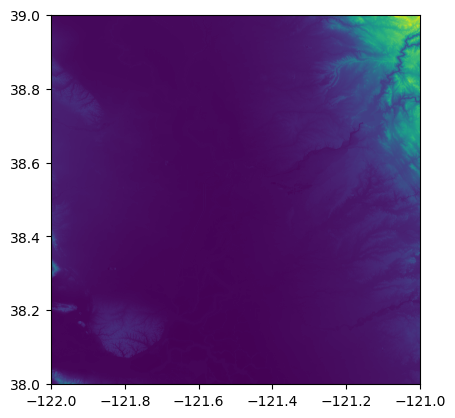

<AxesSubplot: >

In [7]:
# Open the raster image
barea_slope = rasterio.open('H:/mmmiah/Desktop/Bicycle Connectivity Project/Project-Bicycle Connectivity/Davis City Connectivity/slope/USGS_13_n39w122_20220206.tif')
print(barea_slope.crs)
rioplot.show(barea_slope)

In [8]:
# only band is elev value (in m)
band1 = barea_slope.read(1, masked=True)  # mask noData cells [shouldn't be necessary on land]
stats = {'min': band1.min(), 'mean': band1.mean(), 'max': band1.max()}
print(stats)

{'min': -7.3393726, 'mean': 42.889994523835824, 'max': 681.56647}


In [9]:
# Reproject the geometries by replacing the values with projected ones
lts_new = lts.to_crs(epsg=4326)
lts_new.head(10)

,ROAD_ID,osmid,FUNCTIONAL,PATH_ID,ONE_WAY,u,v,WIDTH,SPEED_LIMI,FT_BIKE_IN,...,TWLTL_CROS,FT_PARK,TF_PARK,FT_SEG_STR,FT_INT_STR,TF_SEG_STR,TF_INT_STR,XWALK,geometry,length
0,7898,{249414350},secondary,None,None,1718,559,NaN,NaN,None,...,None,?,?,4,NaN,4.0,NaN,None,"LINESTRING (-121.73108 38.54875, -121.73057 38...",44.448339
1,14841,{617716534},primary,None,ft,2267,3616,NaN,NaN,lane,...,None,?,?,3,NaN,NaN,1.0,None,"LINESTRING (-121.69421 38.55664, -121.69416 38...",13.615555
2,15576,{10747435},tertiary,None,None,1912,3766,NaN,NaN,None,...,None,?,?,4,NaN,4.0,NaN,None,"LINESTRING (-121.82274 38.54698, -121.82314 38...",35.073038
3,15659,{248096977},path,None,None,1982,4081,NaN,NaN,path,...,None,?,?,1,NaN,1.0,1.0,None,"LINESTRING (-121.74386 38.54128, -121.74343 38...",37.430131
4,15999,{990990070},path,None,None,5222,1000,NaN,NaN,path,...,None,?,?,1,1.0,1.0,NaN,None,"LINESTRING (-121.75466 38.54050, -121.75464 38...",5.706566
5,7542,{617716524},secondary,None,ft,5523,2451,NaN,NaN,None,...,None,?,?,4,1.0,NaN,1.0,None,"LINESTRING (-121.70958 38.56418, -121.70957 38...",9.852736
6,7531,{683304805},secondary,None,ft,744,1688,NaN,NaN,lane,...,None,?,?,3,1.0,NaN,1.0,None,"LINESTRING (-121.70532 38.55668, -121.70527 38...",10.342277
7,316,"{25354528,617922203,1060523183}",secondary,None,ft,1535,2554,NaN,35.0,None,...,None,?,?,4,NaN,NaN,NaN,None,"LINESTRING (-121.76732 38.54645, -121.76773 38...",115.355111
8,326,{10745041},motorway_link,None,ft,5974,5364,NaN,NaN,None,...,None,?,?,4,1.0,NaN,NaN,None,"LINESTRING (-121.76739 38.59493, -121.76746 38...",561.788633
9,258,{1063803867},motorway_link,None,ft,1339,4978,NaN,NaN,None,...,None,?,?,4,3.0,NaN,3.0,None,"LINESTRING (-121.76980 38.53677, -121.76981 38...",13.810277


In [10]:
# get the slope for each link of the network
%time
lts_new
# First identify the starting and ending node of each link
lts_new['starting point'] = None
lts_new['ending point'] = None

for index, row in lts_new.iterrows():
    coords = [(coords) for coords in list(row['geometry'].coords)]
    first_coord, last_coord = [ coords[i] for i in (0, -1) ]
    lts_new.at[index,'starting point'] = Point(first_coord)
    lts_new.at[index,'ending point'] = Point(last_coord)
    lts_new

CPU times: total: 0 ns
Wall time: 0 ns


<AxesSubplot: >

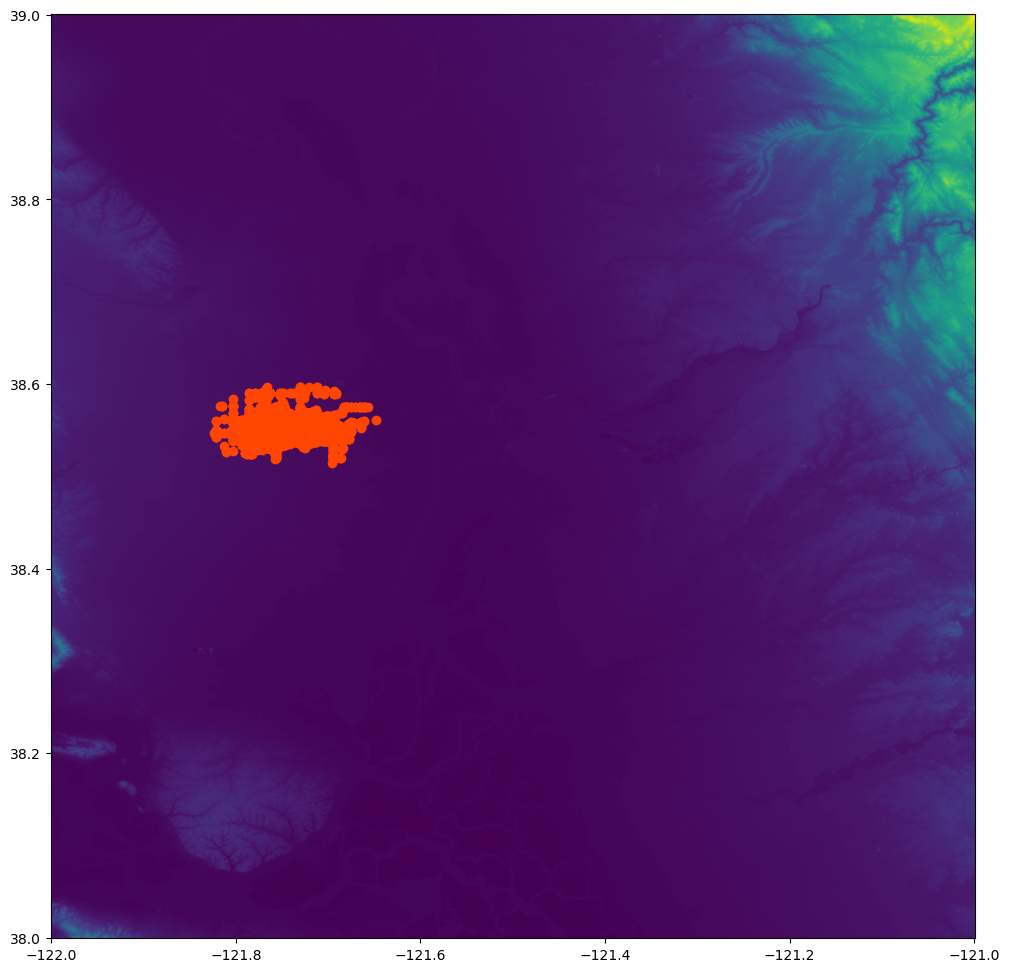

In [11]:
#show point and raster on a matplotlib plot
fig, ax = plt.subplots(figsize=(12,12))
lts_new.boundary.plot(ax=ax, color='orangered')
show(barea_slope, ax=ax)

In [12]:
# Calculate each link starting lat and long
sf1=lts_new.loc[:,["ROAD_ID","starting point"]]
sf1.columns=["ROAD_ID","geometry"]
sf1['start_lon'] = sf1.geometry.apply(lambda p: p.x)
sf1['start_lat'] = sf1.geometry.apply(lambda p: p.y)
sf2=sf1.loc[:,["ROAD_ID","geometry","start_lon","start_lat"]]
sf2.head(5)

,ROAD_ID,geometry,start_lon,start_lat
0,7898,POINT (-121.731084 38.54874530000001),-121.731084,38.548745
1,14841,POINT (-121.69421260000001 38.5566429),-121.694213,38.556643
2,15576,POINT (-121.8227399 38.5469839),-121.822740,38.546984
3,15659,POINT (-121.74385640000001 38.5412802),-121.743856,38.541280
4,15999,POINT (-121.7546551 38.540496299999994),-121.754655,38.540496


In [13]:
# Calculate each link starting elevation
sf2["starting_ele"]= None
#point in test['geometry']:
x = sf2["start_lon"]
y = sf2["start_lat"]
row, col = barea_slope.index(x,y)
sf2["starting_ele"]=barea_slope.read(1)[row,col]

In [14]:
%%time
# Calculate each link end point elevation
ef1=lts_new.loc[:,["ROAD_ID","ending point"]]
ef1.columns=["ROAD_ID","geometry"]
ef1['end_lon'] = ef1.geometry.apply(lambda p: p.x)
ef1['end_lat'] = ef1.geometry.apply(lambda p: p.y)
ef2=ef1.loc[:,["ROAD_ID","geometry","end_lon","end_lat"]]
ef2.head(5)

CPU times: total: 172 ms
Wall time: 157 ms


,ROAD_ID,geometry,end_lon,end_lat
0,7898,POINT (-121.73057430000001 38.5487355),-121.730574,38.548735
1,14841,POINT (-121.694159 38.5565277),-121.694159,38.556528
2,15576,POINT (-121.8231422 38.5469857),-121.823142,38.546986
3,15659,POINT (-121.74343309999999 38.5413364),-121.743433,38.541336
4,15999,POINT (-121.754637 38.54044690000001),-121.754637,38.540447


In [15]:
%%time
# Calculate the each link end elevation
ef2["ending_ele"]= None
#point in test['geometry']:
x = ef2["end_lon"]
y = ef2["end_lat"]
row, col = barea_slope.index(x,y)
ef2["ending_ele"]=barea_slope.read(1)[row,col]

CPU times: total: 266 ms
Wall time: 278 ms


In [16]:
%%time
# Calculate the slope for each link
from functools import reduce
barea_all=[sf2,ef2,lts_new]

barea_all1= reduce(lambda  left,right: pd.merge(left,right,on=['ROAD_ID'],
                                            how='outer'), barea_all).fillna('0')
barea_all1["slope"]=abs((barea_all1['starting_ele']-barea_all1['ending_ele'])/barea_all1['length'])*100
barea_all1=barea_all1.drop_duplicates(subset=['ROAD_ID'], keep='first')
barea_all1.head()

CPU times: total: 93.8 ms
Wall time: 70.8 ms


,ROAD_ID,geometry_x,start_lon,start_lat,starting_ele,geometry_y,end_lon,end_lat,ending_ele,osmid,...,FT_SEG_STR,FT_INT_STR,TF_SEG_STR,TF_INT_STR,XWALK,geometry,length,starting point,ending point,slope
0,7898,POINT (-121.731084 38.54874530000001),-121.731084,38.548745,12.312861,POINT (-121.73057430000001 38.5487355),-121.730574,38.548735,12.072841,{249414350},...,4,0,4.0,0,0,"LINESTRING (-121.73108 38.54875, -121.73057 38...",44.448339,POINT (-121.731084 38.54874530000001),POINT (-121.73057430000001 38.5487355),0.539999
1,14841,POINT (-121.69421260000001 38.5566429),-121.694213,38.556643,8.930607,POINT (-121.694159 38.5565277),-121.694159,38.556528,8.957235,{617716534},...,3,0,0,1.0,0,"LINESTRING (-121.69421 38.55664, -121.69416 38...",13.615555,POINT (-121.69421260000001 38.5566429),POINT (-121.694159 38.5565277),0.195574
2,15576,POINT (-121.8227399 38.5469839),-121.822740,38.546984,23.069754,POINT (-121.8231422 38.5469857),-121.823142,38.546986,23.181372,{10747435},...,4,0,4.0,0,0,"LINESTRING (-121.82274 38.54698, -121.82314 38...",35.073038,POINT (-121.8227399 38.5469839),POINT (-121.8231422 38.5469857),0.318245
3,15659,POINT (-121.74385640000001 38.5412802),-121.743856,38.541280,15.718659,POINT (-121.74343309999999 38.5413364),-121.743433,38.541336,15.605118,{248096977},...,1,0,1.0,1.0,0,"LINESTRING (-121.74386 38.54128, -121.74343 38...",37.430131,POINT (-121.74385640000001 38.5412802),POINT (-121.74343309999999 38.5413364),0.303343
4,15999,POINT (-121.7546551 38.540496299999994),-121.754655,38.540496,14.410607,POINT (-121.754637 38.54044690000001),-121.754637,38.540447,14.439425,{990990070},...,1,1.0,1.0,0,0,"LINESTRING (-121.75466 38.54050, -121.75464 38...",5.706566,POINT (-121.7546551 38.540496299999994),POINT (-121.754637 38.54044690000001),0.504983


<AxesSubplot: >

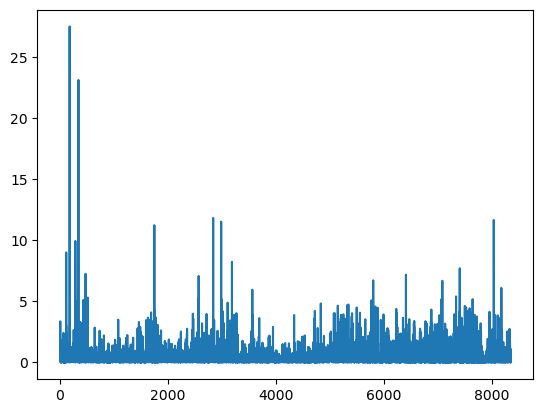

In [17]:
barea_all1.slope.plot()

In [18]:
# write a slope impedance function
def slope_correction(length,FT_SEG_STR,slope):
    if slope <=2:
        return length*(1+FT_SEG_STR)
    elif ((slope>2) and (slope<=4)):
        return length*(1+0.37+FT_SEG_STR)
    elif ((slope>4) and (slope<=6)):
        return length*(1+1.20+FT_SEG_STR)
    else:
        return length*(1+3.20+FT_SEG_STR)

In [19]:
#barea_all1['FT_SEG_STR'].astype(str).astype(int)
barea_all1['FT_SEG_STR']=pd.to_numeric(barea_all1['FT_SEG_STR']).astype(int)
barea_all1['FT_SEG_STR'].dtypes

dtype('int32')

In [20]:
barea_all1['impedance_of_link']=barea_all1.apply(lambda row: slope_correction(row['length'],row['FT_SEG_STR'],row['slope']),axis=1)
barea_all1.head(8)

,ROAD_ID,geometry_x,start_lon,start_lat,starting_ele,geometry_y,end_lon,end_lat,ending_ele,osmid,...,FT_INT_STR,TF_SEG_STR,TF_INT_STR,XWALK,geometry,length,starting point,ending point,slope,impedance_of_link
0,7898,POINT (-121.731084 38.54874530000001),-121.731084,38.548745,12.312861,POINT (-121.73057430000001 38.5487355),-121.730574,38.548735,12.072841,{249414350},...,0,4.0,0,0,"LINESTRING (-121.73108 38.54875, -121.73057 38...",44.448339,POINT (-121.731084 38.54874530000001),POINT (-121.73057430000001 38.5487355),0.539999,222.241697
1,14841,POINT (-121.69421260000001 38.5566429),-121.694213,38.556643,8.930607,POINT (-121.694159 38.5565277),-121.694159,38.556528,8.957235,{617716534},...,0,0,1.0,0,"LINESTRING (-121.69421 38.55664, -121.69416 38...",13.615555,POINT (-121.69421260000001 38.5566429),POINT (-121.694159 38.5565277),0.195574,54.462221
2,15576,POINT (-121.8227399 38.5469839),-121.822740,38.546984,23.069754,POINT (-121.8231422 38.5469857),-121.823142,38.546986,23.181372,{10747435},...,0,4.0,0,0,"LINESTRING (-121.82274 38.54698, -121.82314 38...",35.073038,POINT (-121.8227399 38.5469839),POINT (-121.8231422 38.5469857),0.318245,175.365188
3,15659,POINT (-121.74385640000001 38.5412802),-121.743856,38.541280,15.718659,POINT (-121.74343309999999 38.5413364),-121.743433,38.541336,15.605118,{248096977},...,0,1.0,1.0,0,"LINESTRING (-121.74386 38.54128, -121.74343 38...",37.430131,POINT (-121.74385640000001 38.5412802),POINT (-121.74343309999999 38.5413364),0.303343,74.860262
4,15999,POINT (-121.7546551 38.540496299999994),-121.754655,38.540496,14.410607,POINT (-121.754637 38.54044690000001),-121.754637,38.540447,14.439425,{990990070},...,1.0,1.0,0,0,"LINESTRING (-121.75466 38.54050, -121.75464 38...",5.706566,POINT (-121.7546551 38.540496299999994),POINT (-121.754637 38.54044690000001),0.504983,11.413133
5,7542,POINT (-121.709577 38.5641801),-121.709577,38.564180,11.815551,POINT (-121.7095656 38.56409179999999),-121.709566,38.564092,12.147692,{617716524},...,1.0,0,1.0,0,"LINESTRING (-121.70958 38.56418, -121.70957 38...",9.852736,POINT (-121.709577 38.5641801),POINT (-121.7095656 38.56409179999999),3.371053,52.909191
6,7531,POINT (-121.7053166 38.5566835),-121.705317,38.556683,10.277437,POINT (-121.70527450000002 38.5567706),-121.705275,38.556771,10.217400,{683304805},...,1.0,0,1.0,0,"LINESTRING (-121.70532 38.55668, -121.70527 38...",10.342277,POINT (-121.7053166 38.5566835),POINT (-121.70527450000002 38.5567706),0.580507,41.369108
7,316,POINT (-121.7673155 38.54645360000001),-121.767315,38.546454,18.179966,POINT (-121.7686386 38.54646249999999),-121.768639,38.546462,18.410713,"{25354528,617922203,1060523183}",...,0,0,0,0,"LINESTRING (-121.76732 38.54645, -121.76773 38...",115.355111,POINT (-121.7673155 38.54645360000001),POINT (-121.7686386 38.54646249999999),0.200032,576.775554


### Lets Calculate the Connectivity

## Helper Function

In [21]:
def node_level_connectivity_score (sf_motor_network,sf_bike_network):
    connectivity_score=[]
    sf_lts_motor_g=gpd.GeoDataFrame.explode(sf_motor_network)
    sf_lts_motor_g1 =momepy.gdf_to_nx(sf_lts_motor_g, approach='primal')
    #https://www.programcreek.com/python/example/120188/networkx.all_pairs_dijkstra_path_length
    motor_length = dict(nx.all_pairs_dijkstra_path_length(sf_lts_motor_g1,cutoff=39590, weight='impedance_of_link'))
    # Convert the shorsted path distance distionary to dataframe
    sf_sheortst_path_motor_length=pd.DataFrame.from_dict(motor_length)
    # Calculate the total motor path
    sf_sheortst_path_motor_length['total_motor_path']=sf_sheortst_path_motor_length.sum(numeric_only=True, axis=0)
    sf_sheortst_path_motor_length1=sf_sheortst_path_motor_length[['total_motor_path']]
    # make total motor path as dictonary
    ms_outcomes=sf_sheortst_path_motor_length1.T.to_dict('list')
    # add motor path attribute with grpah nodes
    nx.set_node_attributes(sf_lts_motor_g1, values=ms_outcomes, name="total_motor_path")
    nodes_motor, edges_motor = momepy.nx_to_gdf(sf_lts_motor_g1)
    nodes_motor['total_motor_path'] = nodes_motor['total_motor_path'].str[0]
    
    
    # do it for bike Path
    sf_lts_bike_g=gpd.GeoDataFrame.explode(sf_bike_network)
    sf_lts_bike_g1 =momepy.gdf_to_nx(sf_lts_bike_g, approach='primal')
    #https://www.programcreek.com/python/example/120188/networkx.all_pairs_dijkstra_path_length
    bike_length = dict(nx.all_pairs_dijkstra_path_length(sf_lts_bike_g1,cutoff=39590, weight='impedance_of_link'))
    # Convert the shorsted path distance distionary to dataframe
    sf_shortest_path_bike_length=pd.DataFrame.from_dict(bike_length)
    # Calculate the total bike path
    sf_shortest_path_bike_length['total_bike_path']=sf_shortest_path_bike_length.sum(numeric_only=True, axis=0)
    sf_shortest_path_bike_length1=sf_shortest_path_bike_length[['total_bike_path']]
    # make total motor path as dictonary
    bs_outcomes=sf_shortest_path_bike_length1.T.to_dict('list')
    # add motor path attribute with grpah nodes
    nx.set_node_attributes(sf_lts_bike_g1, values=bs_outcomes, name="total_bike_path")
    nodes_bike, edges_bike = momepy.nx_to_gdf(sf_lts_bike_g1)
    nodes_bike['total_bike_path'] = nodes_bike['total_bike_path'].str[0]

    #connectivity score
    shortest_path=pd.merge(nodes_motor,nodes_bike,on=['geometry'],how='outer')
    shortest_path1=shortest_path.fillna(0)
    shortest_path1['CS']= shortest_path1['total_bike_path']/shortest_path1['total_motor_path']
    shortest_path1= shortest_path1.replace(np.inf, 999)
    return shortest_path1 


In [22]:
def count_census_block(Connectivity_score):
    if Connectivity_score>=1:
        return 'excellently connected'
    elif (Connectivity_score>=0.90 and Connectivity_score<1.0):
        return 'very well connected  '
    elif (Connectivity_score>=0.60 and Connectivity_score<0.90):
        return 'well connected'
    elif (Connectivity_score>=0.30 and Connectivity_score<0.60):
        return 'fairly connected'
    else:
        return 'poorly connected'

In [23]:
def census_node_level_connectivity_score (sf_connectivity,input_census_tract):
    census_score=gpd.sjoin(sf_connectivity,input_census_tract)
    census_score1=pd.DataFrame({'Meadian CS':census_score.groupby(['GISJOIN'])['CS'].median()}).reset_index()
    census_score2=pd.merge(census_score1,input_census_tract, on=['GISJOIN'], how='inner' )
    return census_score2 

## Connectivity

In [24]:
# Bring US Census track
census_track=gpd.read_file('H:/mmmiah/Desktop/Bicycle Connectivity Project/Project-Bicycle Connectivity/Bay Area_LTS/US_tract_2020.shp')
census_track1=census_track.to_crs(epsg=7131)
census_track1.head()

,GISJOIN,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,Shape_Leng,Shape_Area,geometry
0,G0100010020100,01,001,020100,01001020100,201,Census Tract 201,G5020,S,9825304.0,28435.0,+32.4819731,-086.4915648,16217.763443,9.853735e+06,"POLYGON ((3516926.098 77059.002, 3516963.104 7..."
1,G0100010020200,01,001,020200,01001020200,202,Census Tract 202,G5020,S,3320818.0,5669.0,+32.4757580,-086.4724678,9824.372415,3.326483e+06,"POLYGON ((3519482.809 73938.168, 3519490.446 7..."
2,G0100010020300,01,001,020300,01001020300,203,Census Tract 203,G5020,S,5349271.0,9054.0,+32.4740243,-086.4597033,10519.641206,5.358327e+06,"POLYGON ((3521117.478 74718.075, 3521099.105 7..."
3,G0100010020400,01,001,020400,01001020400,204,Census Tract 204,G5020,S,6384282.0,8408.0,+32.4710304,-086.4448353,12521.196228,6.392683e+06,"POLYGON ((3521674.809 77662.170, 3521681.008 7..."
4,G0100010020501,01,001,020501,01001020501,205.01,Census Tract 205.01,G5020,S,6203654.0,0.0,+32.4478607,-086.4225578,11422.446991,6.203654e+06,"POLYGON ((3525078.936 76191.813, 3525244.092 7..."


In [25]:
# read the Davis boundary shape file
study_bd=gpd.read_file("H:/mmmiah/Desktop/Bicycle Connectivity Project/Project-Bicycle Connectivity/Davis City Connectivity/Davis_City_Shape/City_of_Davis_Boundary.shp")
study_bd

,OBJECTID,CITYCODE,CITY_NAME,SQ_MILES,ACRES,GlobalID,SHAPE_Leng,SHAPE_Area,geometry
0,3,None,Davis,9.926877,6353.200981,{8E8354F3-0188-49F2-AE1F-F1AE13B3B12E},0.356762,0.00269,"POLYGON ((-121.74783 38.57547, -121.74568 38.5..."


<AxesSubplot: >

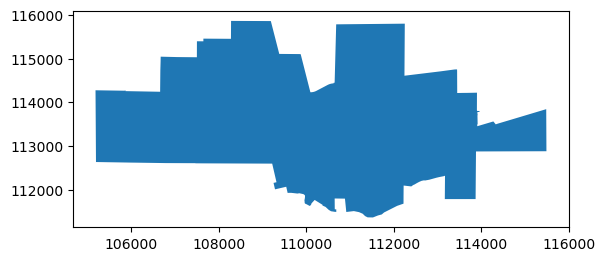

In [26]:
sf_bd_proj = study_bd.to_crs(epsg=7131)
sf_bd_proj.plot()

In [27]:
census_track2=gpd.clip(census_track1,sf_bd_proj)
census_track2.head()

C:\Users\mmmiah\Anaconda3\envs\geo_env\Lib\site-packages\geopandas\tools\clip.py:67: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


,GISJOIN,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,Shape_Leng,Shape_Area,geometry
12648,G0600950253300,06,095,253300,06095253300,2533,Census Tract 2533,G5020,S,442728074.0,2198910.0,+38.4198882,-121.7998024,123158.067002,4.449270e+08,"MULTIPOLYGON (((110019.341 111667.333, 110026...."
13249,G0601130010401,06,113,010401,06113010401,104.01,Census Tract 104.01,G5020,S,348856897.0,8188502.0,+38.4284581,-121.6491713,89877.146298,3.570455e+08,"POLYGON ((113865.435 111805.693, 113865.830 11..."
13251,G0601130010501,06,113,010501,06113010501,105.01,Census Tract 105.01,G5020,S,13594500.0,0.0,+38.5369244,-121.7848197,19757.633627,1.359450e+07,"MULTIPOLYGON (((105193.571 112647.576, 105194...."
13261,G0601130010607,06,113,010607,06113010607,106.07,Census Tract 106.07,G5020,S,3538352.0,0.0,+38.5407306,-121.7024346,8346.169693,3.538353e+06,"POLYGON ((113861.957 113385.440, 113862.237 11..."
13262,G0601130010608,06,113,010608,06113010608,106.08,Census Tract 106.08,G5020,S,2121573.0,0.0,+38.5412556,-121.7230816,7160.791989,2.121574e+06,"POLYGON ((112150.914 111662.855, 112076.374 11..."


In [28]:
census_track2.to_file("H:/mmmiah/Desktop/Bicycle Connectivity Project/Project-Bicycle Connectivity/Davis City Connectivity/Davis_City_Shape/Davis_City_cnesus_Tract.shp")

In [29]:
sf_bd_proj['area']=sf_bd_proj['geometry'].area*3.861e-7 # mile square
sf_bd_proj

,OBJECTID,CITYCODE,CITY_NAME,SQ_MILES,ACRES,GlobalID,SHAPE_Leng,SHAPE_Area,geometry,area
0,3,None,Davis,9.926877,6353.200981,{8E8354F3-0188-49F2-AE1F-F1AE13B3B12E},0.356762,0.00269,"POLYGON ((109189.169 115860.705, 109381.779 11...",10.050553


In [30]:
sf_area=sf_bd_proj[['area']].sum()
sf_area

area    10.050553
dtype: float64

In [31]:
barea_all2 = gpd.GeoDataFrame(barea_all1, crs="EPSG:4326", geometry='geometry')
barea_all3=barea_all2.to_crs(epsg=7131)
barea_all3.head()

,ROAD_ID,geometry_x,start_lon,start_lat,starting_ele,geometry_y,end_lon,end_lat,ending_ele,osmid,...,FT_INT_STR,TF_SEG_STR,TF_INT_STR,XWALK,geometry,length,starting point,ending point,slope,impedance_of_link
0,7898,POINT (-121.731084 38.54874530000001),-121.731084,38.548745,12.312861,POINT (-121.73057430000001 38.5487355),-121.730574,38.548735,12.072841,{249414350},...,0,4.0,0,0,"LINESTRING (110671.553 112905.829, 110715.995 ...",44.448339,POINT (-121.731084 38.54874530000001),POINT (-121.73057430000001 38.5487355),0.539999,222.241697
1,14841,POINT (-121.69421260000001 38.5566429),-121.694213,38.556643,8.930607,POINT (-121.694159 38.5565277),-121.694159,38.556528,8.957235,{617716534},...,0,0,1.0,0,"LINESTRING (113878.653 113808.321, 113883.431 ...",13.615555,POINT (-121.69421260000001 38.5566429),POINT (-121.694159 38.5565277),0.195574,54.462221
2,15576,POINT (-121.8227399 38.5469839),-121.822740,38.546984,23.069754,POINT (-121.8231422 38.5469857),-121.823142,38.546986,23.181372,{10747435},...,0,4.0,0,0,"LINESTRING (102682.700 112651.800, 102647.627 ...",35.073038,POINT (-121.8227399 38.5469839),POINT (-121.8231422 38.5469857),0.318245,175.365188
3,15659,POINT (-121.74385640000001 38.5412802),-121.743856,38.541280,15.718659,POINT (-121.74343309999999 38.5413364),-121.743433,38.541336,15.605118,{248096977},...,0,1.0,1.0,0,"LINESTRING (109564.470 112068.503, 109601.328 ...",37.430131,POINT (-121.74385640000001 38.5412802),POINT (-121.74343309999999 38.5413364),0.303343,74.860262
4,15999,POINT (-121.7546551 38.540496299999994),-121.754655,38.540496,14.410607,POINT (-121.754637 38.54044690000001),-121.754637,38.540447,14.439425,{990990070},...,1.0,1.0,0,0,"LINESTRING (108623.643 111974.308, 108625.263 ...",5.706566,POINT (-121.7546551 38.540496299999994),POINT (-121.754637 38.54044690000001),0.504983,11.413133


In [32]:
# Now lets crop the alameda area of lTS network
sf_lts=gpd.clip(barea_all3,sf_bd_proj)
sf_lts.head()

C:\Users\mmmiah\Anaconda3\envs\geo_env\Lib\site-packages\geopandas\tools\clip.py:67: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


,ROAD_ID,geometry_x,start_lon,start_lat,starting_ele,geometry_y,end_lon,end_lat,ending_ele,osmid,...,FT_INT_STR,TF_SEG_STR,TF_INT_STR,XWALK,geometry,length,starting point,ending point,slope,impedance_of_link
1449,3520,POINT (-121.73166950000001 38.5361913),-121.731670,38.536191,12.471836,POINT (-121.72683249999999 38.5364609),-121.726832,38.536461,14.684669,{32476247},...,0,1.0,0,0,"MULTILINESTRING ((110631.399 111511.817, 11064...",431.430894,POINT (-121.73166950000001 38.5361913),POINT (-121.72683249999999 38.5364609),0.512905,862.861789
1448,3521,POINT (-121.72678500000002 38.53685529999999),-121.726785,38.536855,14.334877,POINT (-121.72683249999999 38.5364609),-121.726832,38.536461,14.684669,"{570174498,32476247}",...,0,1.0,0,0,"LINESTRING (111056.705 111588.865, 111059.824 ...",47.104976,POINT (-121.72678500000002 38.53685529999999),POINT (-121.72683249999999 38.5364609),0.742579,94.209953
1484,4494,POINT (-121.73166950000001 38.5361913),-121.731670,38.536191,12.471836,POINT (-121.7318832 38.53618949999999),-121.731883,38.536189,12.484120,{32476247},...,0,1.0,0,0,"LINESTRING (110631.399 111511.817, 110622.853 ...",18.706652,POINT (-121.73166950000001 38.5361913),POINT (-121.7318832 38.53618949999999),0.065668,37.413305
2329,2690,POINT (-121.7318832 38.53618949999999),-121.731883,38.536189,12.484120,POINT (-121.73236700000001 38.53710300000001),-121.732367,38.537103,14.921537,{32476247},...,1.0,1.0,0,0,"LINESTRING (110612.768 111511.471, 110586.565 ...",129.328597,POINT (-121.7318832 38.53618949999999),POINT (-121.73236700000001 38.53710300000001),1.884670,258.657193
95,2691,POINT (-121.73241299999998 38.537106),-121.732413,38.537106,15.001275,POINT (-121.73236700000001 38.53710300000001),-121.732367,38.537103,14.921537,{10746930},...,1.0,0,1.0,0,"LINESTRING (110565.780 111612.851, 110567.771 ...",4.054351,POINT (-121.73241299999998 38.537106),POINT (-121.73236700000001 38.53710300000001),1.966718,8.108702


In [33]:
# Convert the LTS shape file to graph to run the 
sf_lts_g=gpd.GeoDataFrame.explode(sf_lts)
sf_lts_g1 =momepy.gdf_to_nx(sf_lts_g, approach='primal')

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_18072\1286791951.py:2: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_g=gpd.GeoDataFrame.explode(sf_lts)


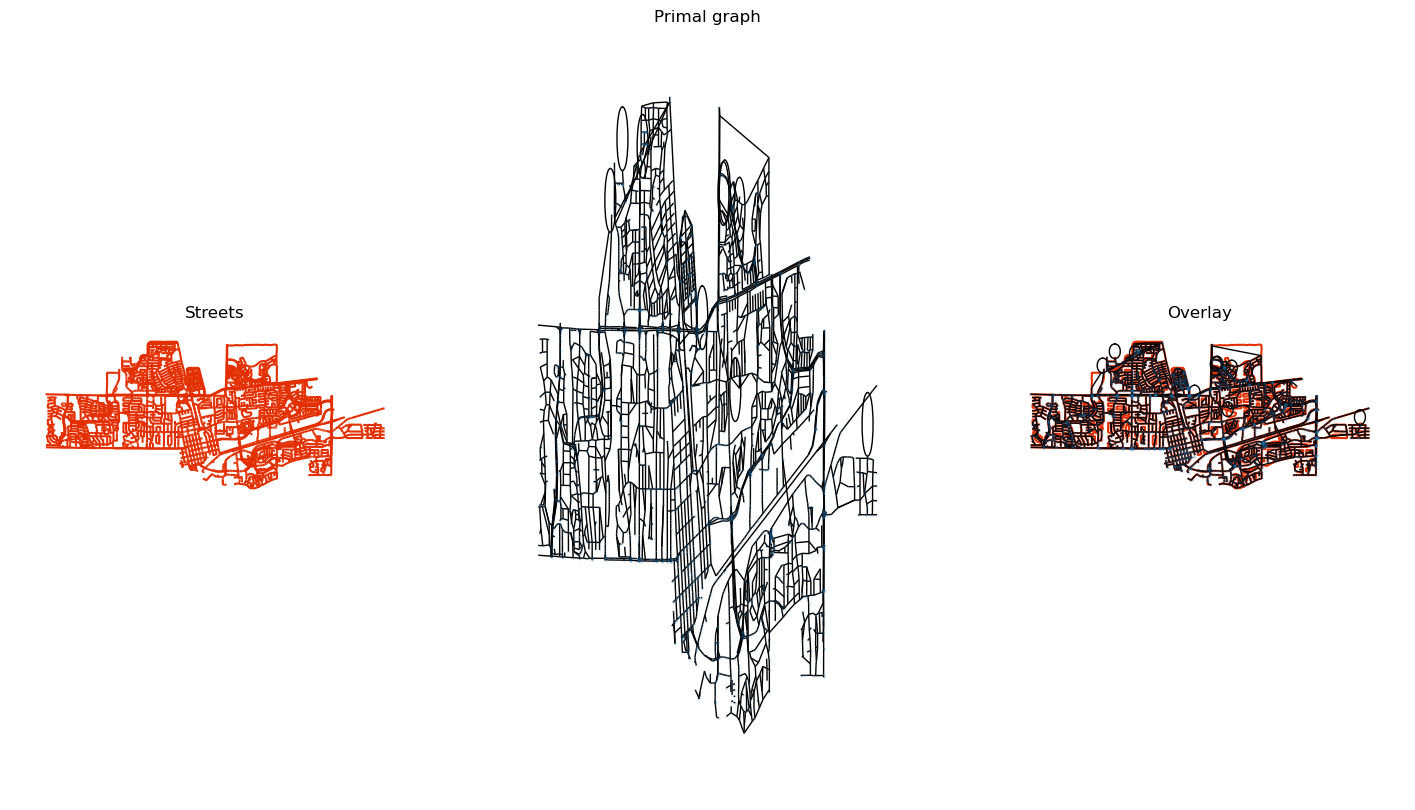

In [34]:
  f, ax = plt.subplots(1, 3, figsize=(18, 10), sharex=True, sharey=True)
  sf_lts.plot(color='#e32e00', ax=ax[0])
  for i, facet in enumerate(ax):
      facet.set_title(("Streets", "Primal graph", "Overlay")[i])
      facet.axis("off")
  nx.draw(sf_lts_g1, {n:[n[0], n[1]] for n in list(sf_lts_g1.nodes)}, ax=ax[1], node_size=0.01)
  sf_lts.plot(color='#e32e00', ax=ax[2], zorder=-1)
  nx.draw(sf_lts_g1, {n:[n[0], n[1]] for n in list(sf_lts_g1.nodes)}, ax=ax[2], node_size=0.01)

<AxesSubplot: >

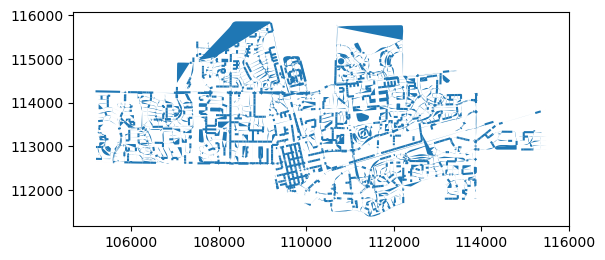

In [35]:
sf_lts['geometry'].convex_hull.plot()

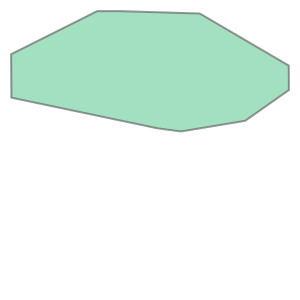

In [36]:
# Get the Convex Hull of the network
convex_hull_area = sf_lts.unary_union.convex_hull
# Show output
convex_hull_area

C:\Users\mmmiah\Anaconda3\envs\geo_env\Lib\site-packages\geopandas\tools\clip.py:67: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


<AxesSubplot: >

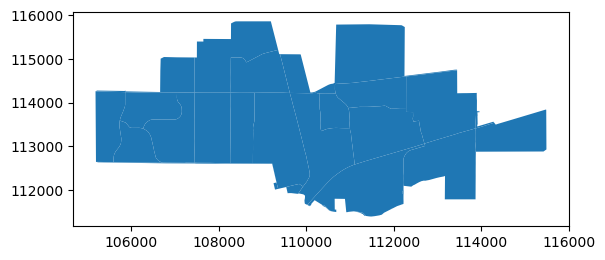

In [37]:
census_track3_sf=gpd.clip(census_track2,convex_hull_area)
census_track3_sf.plot()

In [38]:
convex_hull_area1=convex_hull_area.area
convex_hull_area1

34011948.53461462

In [39]:
# Calculate the number of Intersections
crossroad_nodes = [node for node in sf_lts_g1.nodes() if len(sf_lts_g1.edges(node)) > 2]

In [40]:
def get_number_of_elements(list):
    count = 0
    for element in list:
        count += 1
    return count

#print("Number of elements in the list: ", get_number_of_elements(list_c))

In [41]:
# Number of intersections where edge>2
NI=get_number_of_elements(crossroad_nodes)
NI

2511

# Bicycle Vs Motor Network Connectivity

<AxesSubplot: >

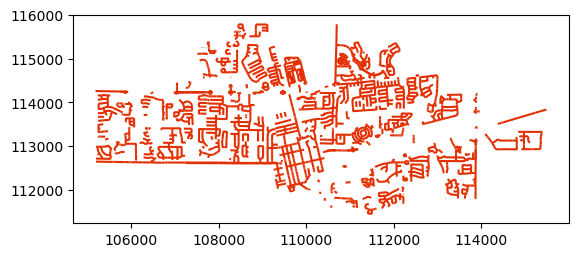

In [42]:
# Get the motorway network and bike network based on functional class of the roads
#sf_motor_network=sf_lts[sf_lts['BIKE_LANE_'].isna()]
sf_motor_network=sf_lts.loc[sf_lts['FT_BIKE_IN']=='0']
# Plot the motor Network
sf_motor_network.plot(color='#e32e00')

In [43]:
sf_motor_network.groupby(['FT_SEG_STR'])['FT_SEG_STR'].count()

FT_SEG_STR
1    1987
2      35
3      23
4     464
Name: FT_SEG_STR, dtype: int64

<AxesSubplot: >

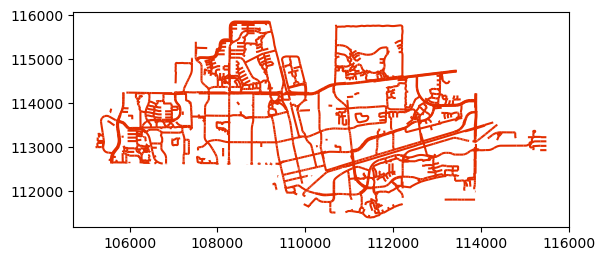

In [44]:
# Plot the Bike Network
sf_bike_network=sf_lts.loc[sf_lts['FT_BIKE_IN']!='0']
sf_bike_network.plot(color='#e32e00')

In [45]:
sf_bike_network.groupby(['FT_SEG_STR'])['FT_SEG_STR'].count()

FT_SEG_STR
1    1965
3    1379
4      28
Name: FT_SEG_STR, dtype: int64

In [46]:
input_census_tract=census_track2.reset_index()
input_census_tract.shape

(20, 17)

In [47]:
al_connectivity=node_level_connectivity_score (sf_motor_network,sf_bike_network)
al_connectivity.head()

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_18072\4200728652.py:3: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd.GeoDataFrame.explode(sf_motor_network)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_18072\4200728652.py:21: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd.GeoDataFrame.explode(sf_bike_network)


,total_motor_path,nodeID_x,geometry,total_bike_path,nodeID_y,CS
0,132.490898,0.0,POINT (110565.780 111612.851),0.000000,0.0,0.00000
1,129.313800,1.0,POINT (110569.793 111612.549),1713.659977,6.0,13.25195
2,129.313800,2.0,POINT (110574.040 111614.703),0.000000,0.0,0.00000
3,137.718166,3.0,POINT (110576.354 111618.840),0.000000,0.0,0.00000
4,180.309321,4.0,POINT (110562.009 111625.611),0.000000,0.0,0.00000


In [48]:
# overall Area Connectivity
BMN_Area_CS=al_connectivity['total_bike_path'].sum()/al_connectivity['total_motor_path'].sum()
BMN_Area_CS

52.685402625574994

In [49]:
al_connectivity['CS'].median()

999.0

In [50]:
# Save the Alamenda County node level Connectivity
crs = {'init': 'epsg:7131'}
gdf_al = gpd.GeoDataFrame(al_connectivity, crs=crs, geometry = 'geometry')
gdf_al.to_file("H:/mmmiah/Desktop/Bicycle Connectivity Project/Project-Bicycle Connectivity/Nodel Level Connectivity_results/Davis_BMN_node_level_connectivity.shp")

C:\Users\mmmiah\Anaconda3\envs\geo_env\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_18072\3513562792.py:4: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_al.to_file("H:/mmmiah/Desktop/Bicycle Connectivity Project/Project-Bicycle Connectivity/Nodel Level Connectivity_results/Davis_BMN_node_level_connectivity.shp")


In [51]:
input_census_tract=census_track3_sf.reset_index()
input_census_tract.shape

(20, 17)

In [52]:
# save the results by Census Tract
CS_median=census_node_level_connectivity_score (al_connectivity,input_census_tract)
CS_median.head()

,GISJOIN,Meadian CS,index,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,Shape_Leng,Shape_Area,geometry
0,G0600950253300,499.500000,12648,06,095,253300,06095253300,2533,Census Tract 2533,G5020,S,442728074.0,2198910.0,+38.4198882,-121.7998024,123158.067002,4.449270e+08,"MULTIPOLYGON (((110026.344 111675.047, 110038...."
1,G0601130010401,999.000000,13249,06,113,010401,06113010401,104.01,Census Tract 104.01,G5020,S,348856897.0,8188502.0,+38.4284581,-121.6491713,89877.146298,3.570455e+08,"POLYGON ((113865.830 111842.554, 113866.767 11..."
2,G0601130010501,8.575943,13251,06,113,010501,06113010501,105.01,Census Tract 105.01,G5020,S,13594500.0,0.0,+38.5369244,-121.7848197,19757.633627,1.359450e+07,"MULTIPOLYGON (((105201.941 112647.524, 105206...."
3,G0601130010505,57.886267,13252,06,113,010505,06113010505,105.05,Census Tract 105.05,G5020,S,136298933.0,1005494.0,+38.6029781,-121.7398412,70161.185468,1.373044e+08,"MULTIPOLYGON (((114031.779 113459.443, 113878...."
4,G0601130010508,999.000000,13253,06,113,010508,06113010508,105.08,Census Tract 105.08,G5020,S,2466748.0,61756.0,+38.5541465,-121.7985136,6900.455402,2.528503e+06,"POLYGON ((105859.777 114187.032, 105860.050 11..."


In [53]:
# Import the node Connectivity
crs = {'init': 'epsg:7131'}
CS_median1 = gpd.GeoDataFrame(CS_median, crs=crs, geometry = 'geometry')
CS_median1.to_file("H:/mmmiah/Desktop/Bicycle Connectivity Project/Project-Bicycle Connectivity/Nodel Level Connectivity_results/Davis_Census_level_Median_BMN_CS.shp")

C:\Users\mmmiah\Anaconda3\envs\geo_env\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


# Assign the Grade of the Connectivity for Bike Network-micro connectivity

In [54]:
CS_median['cs_ranking']=CS_median.apply(lambda row:count_census_block(row['Meadian CS']),axis=1 )
# Now count the census tract for Bay area by cs ranking
CS_median.groupby(['cs_ranking'])['GISJOIN'].count()

cs_ranking
excellently connected    19
poorly connected          1
Name: GISJOIN, dtype: int64

# Assign the Grade of the Connectivity for Bike Network-macro connectivity

In [55]:
# Join the nodel level shortest path results with census tract
AC=gpd.sjoin(al_connectivity,input_census_tract)
# aggregrate total bike path by census tract
AC1=pd.DataFrame({'total_bike_path':AC.groupby(['GISJOIN'])['total_bike_path'].sum()}).reset_index()
# aggregrate total motor path by census tract
AC2=pd.DataFrame({'total_motor_path':AC.groupby(['GISJOIN'])['total_motor_path'].sum()}).reset_index()
# join total bike and motor path processing data by census tract GISJOIN id
ACS=pd.merge(AC1, AC2, on=['GISJOIN'], how='inner')
# calculate area connectivity by each census tract
ACS['ACS']=ACS['total_bike_path']/ACS['total_motor_path']
# assigm the grade of the census tract
ACS['cs_ranking']=ACS.apply(lambda row:count_census_block(row['ACS']),axis=1 )
# Now count the census tract for Bay area by cs ranking
ACS.groupby(['cs_ranking'])['GISJOIN'].count()

cs_ranking
excellently connected    19
poorly connected          1
Name: GISJOIN, dtype: int64

# Calculate Low Stress Network Connectivity

<AxesSubplot: >

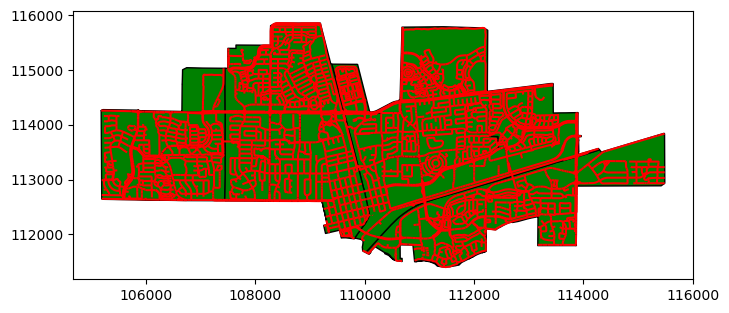

In [56]:
fig, ax = plt.subplots(figsize = (8,8)) 
census_track3_sf.plot(ax=ax,color="green",edgecolor='k')
sf_lts.geometry.plot(color="red",edgecolor='k',ax=ax)

In [57]:
# Split the network as low network to get the connectivity 
sf_motor_network_op2=sf_motor_network
sf_low_stress_network_op2=sf_lts.loc[sf_lts['FT_SEG_STR']<3]

In [58]:
node_level_MLN_CS= node_level_connectivity_score(sf_motor_network_op2,sf_low_stress_network_op2)
node_level_MLN_CS.head()

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_18072\4200728652.py:3: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd.GeoDataFrame.explode(sf_motor_network)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_18072\4200728652.py:21: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd.GeoDataFrame.explode(sf_bike_network)


,total_motor_path,nodeID_x,geometry,total_bike_path,nodeID_y,CS
0,132.490898,0.0,POINT (110565.780 111612.851),1870.476980,7.0,14.117777
1,129.313800,1.0,POINT (110569.793 111612.549),1842.973776,6.0,14.251950
2,129.313800,2.0,POINT (110574.040 111614.703),1871.860937,8.0,14.475338
3,137.718166,3.0,POINT (110576.354 111618.840),1914.338145,9.0,13.900404
4,180.309321,4.0,POINT (110562.009 111625.611),2011.489331,10.0,11.155770


In [59]:
# overall Area Connectivity
LMN_Area_CS=node_level_MLN_CS['total_bike_path'].sum()/node_level_MLN_CS['total_motor_path'].sum()
LMN_Area_CS

26.176892102021274

In [60]:
node_level_MLN_CS['CS'].median()

714.1487068933511

In [61]:
# Import the node Connectivity
crs = {'init': 'epsg:7131'}
sfcs1 = gpd.GeoDataFrame(node_level_MLN_CS, crs=crs, geometry = 'geometry')
sfcs1.to_file("H:/mmmiah/Desktop/Bicycle Connectivity Project/Project-Bicycle Connectivity/Nodel Level Connectivity_results/Davis_node_level_LMN_CS.shp")

C:\Users\mmmiah\Anaconda3\envs\geo_env\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_18072\3123757587.py:4: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  sfcs1.to_file("H:/mmmiah/Desktop/Bicycle Connectivity Project/Project-Bicycle Connectivity/Nodel Level Connectivity_results/Davis_node_level_LMN_CS.shp")


In [62]:
CS_median1=census_node_level_connectivity_score (node_level_MLN_CS,input_census_tract)
CS_median1.head()

,GISJOIN,Meadian CS,index,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,Shape_Leng,Shape_Area,geometry
0,G0600950253300,1191.999873,12648,06,095,253300,06095253300,2533,Census Tract 2533,G5020,S,442728074.0,2198910.0,+38.4198882,-121.7998024,123158.067002,4.449270e+08,"MULTIPOLYGON (((110026.344 111675.047, 110038...."
1,G0601130010401,1.863106,13249,06,113,010401,06113010401,104.01,Census Tract 104.01,G5020,S,348856897.0,8188502.0,+38.4284581,-121.6491713,89877.146298,3.570455e+08,"POLYGON ((113865.830 111842.554, 113866.767 11..."
2,G0601130010501,8.384323,13251,06,113,010501,06113010501,105.01,Census Tract 105.01,G5020,S,13594500.0,0.0,+38.5369244,-121.7848197,19757.633627,1.359450e+07,"MULTIPOLYGON (((105201.941 112647.524, 105206...."
3,G0601130010505,146.335222,13252,06,113,010505,06113010505,105.05,Census Tract 105.05,G5020,S,136298933.0,1005494.0,+38.6029781,-121.7398412,70161.185468,1.373044e+08,"MULTIPOLYGON (((114031.779 113459.443, 113878...."
4,G0601130010508,130.814175,13253,06,113,010508,06113010508,105.08,Census Tract 105.08,G5020,S,2466748.0,61756.0,+38.5541465,-121.7985136,6900.455402,2.528503e+06,"POLYGON ((105859.777 114187.032, 105860.050 11..."


In [63]:
# Import the node Connectivity
crs = {'init': 'epsg:7131'}
CS_median2 = gpd.GeoDataFrame(CS_median1, crs=crs, geometry = 'geometry')
CS_median2.to_file("H:/mmmiah/Desktop/Bicycle Connectivity Project/Project-Bicycle Connectivity/Nodel Level Connectivity_results/Davis_census_level_LMN_CS.shp")

C:\Users\mmmiah\Anaconda3\envs\geo_env\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


# Assign the Grade of the Connectivity for Bike Network-micro connectivity

In [64]:
CS_median1 ['cs_ranking']=CS_median1 .apply(lambda row:count_census_block(row['Meadian CS']),axis=1 )
# Now count the census tract for Bay area by cs ranking
CS_median1.groupby(['cs_ranking'])['GISJOIN'].count()

cs_ranking
excellently connected    19
poorly connected          1
Name: GISJOIN, dtype: int64

# Assign the Grade of the Connectivity for low stress Network-macro connectivity

In [65]:
# Join the nodel level shortest path results with census tract
AC=gpd.sjoin(node_level_MLN_CS,input_census_tract)
# aggregrate total bike path by census tract
AC1=pd.DataFrame({'total_bike_path':AC.groupby(['GISJOIN'])['total_bike_path'].sum()}).reset_index()
# aggregrate total motor path by census tract
AC2=pd.DataFrame({'total_motor_path':AC.groupby(['GISJOIN'])['total_motor_path'].sum()}).reset_index()
# join total bike and motor path processing data by census tract GISJOIN id
ACS=pd.merge(AC1, AC2, on=['GISJOIN'], how='inner')
# calculate area connectivity by each census tract
ACS['ACS']=ACS['total_bike_path']/ACS['total_motor_path']
# assigm the grade of the census tract
ACS['cs_ranking']=ACS.apply(lambda row:count_census_block(row['ACS']),axis=1 )
# Now count the census tract for Bay area by cs ranking
ACS.groupby(['cs_ranking'])['GISJOIN'].count()

cs_ranking
excellently connected    18
fairly connected          2
Name: GISJOIN, dtype: int64

# End of coding